# SOM (Koholen Maps)

SOM (Self-Organizing Maps) is a type of artificial neural network that is trained using unsupervised learning to produce a low-dimensional (typically two-dimensional), discretized representation of the input space of the training samples. The SOM algorithm uses competitive learning to train the neurons to represent the input data in a way that preserves the topological properties of the input space. The SOM algorithm is also known as Kohonen Maps, named after Teuvo Kohonen, the inventor of the algorithm.


## Setup


### Set Random State Seed


In [1]:
import math
import random
import numpy as np

seed = 42
random.seed(seed)
np.random.seed(seed)

### Import external lib


In [2]:
import os
import sys

project_root = os.path.abspath(
    os.path.join(os.getcwd(), os.pardir, os.pardir, os.pardir)
)
if project_root not in sys.path:
    sys.path.append(project_root)

try:
    from src.data_loader.mnist_dataset import load_mnist_data
    from src.data_loader.toy_dataset import load_toy_data
    from src.data_loader.custom_dataset import load_custom_dataset
    from src.algorithms.som.som import SOM
except ModuleNotFoundError as e:
    print(e)

C:\Users\erwan\Desktop\ESGI\S10\Unsupervised deep learning\Projet\data\models\auto_encoder
C:\Users\erwan\Desktop\ESGI\S10\Unsupervised deep learning\Projet\data\models\gan
C:\Users\erwan\Desktop\ESGI\S10\Unsupervised deep learning\Projet\data\models\k_means
C:\Users\erwan\Desktop\ESGI\S10\Unsupervised deep learning\Projet\data\models\pca
C:\Users\erwan\Desktop\ESGI\S10\Unsupervised deep learning\Projet\data\models\som
C:\Users\erwan\Desktop\ESGI\S10\Unsupervised deep learning\Projet\data\models\vae


### Test on toy data


100%|██████████| 100/100 [00:00<00:00, 4348.28it/s]


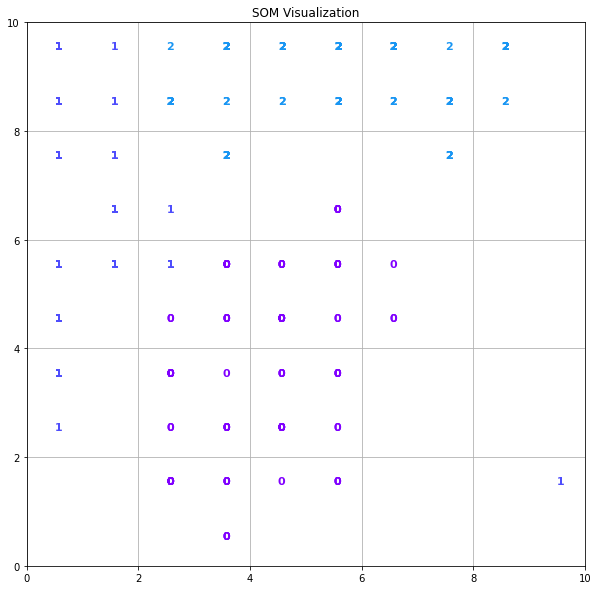

In [3]:
import matplotlib.pyplot as plt

data, labels = load_toy_data(n_samples=300, n_features=2, n_clusters=3, random_state=42)

toy_som = SOM(x=10, y=10, input_dim=2, learning_rate=0.5, sigma=3.0)
toy_som.train(data, num_iterations=100)

plt.figure(figsize=(10, 10))
for i, (x, y) in enumerate(toy_som.map_vects(data)):
    plt.text(
        x + 0.5,
        y + 0.5,
        str(labels[i]),
        color=plt.cm.rainbow(labels[i] / 10.0),
        fontdict={"weight": "bold", "size": 11},
    )
plt.xlim([0, toy_som.x])
plt.ylim([0, toy_som.y])
plt.grid()
plt.title("SOM Visualization")
plt.show()

## Load MNIST Dataset


In [4]:
(x_train, y_train), (x_test, y_test) = load_mnist_data()

### Preprocessing


In [5]:
from sklearn.preprocessing import MinMaxScaler

data_normalized = MinMaxScaler().fit_transform(x_train)

In [6]:
x_train = x_train.reshape(x_train.shape[0], -1) / 255.0
x_test = x_test.reshape(x_test.shape[0], -1) / 255.0

In [7]:
mnist_som = SOM(x=20, y=20, input_dim=28 * 28, learning_rate=5e-2, sigma=5.0)
mnist_som.train(x_train, num_iterations=10000)

100%|██████████| 10000/10000 [00:31<00:00, 318.24it/s]


In [8]:
import matplotlib.animation as animation
from tqdm import tqdm

def visualize_som(som: SOM, data: np.ndarray, labels: np.ndarray, title: str):
    plt.figure(figsize=(10, 10))
    for i, (x, y) in enumerate(som.map_vects(data)):
        plt.text(
            x + 0.5,
            y + 0.5,
            str(labels[i]),
            color=plt.cm.rainbow(labels[i] / 10.0),
            fontdict={"weight": "bold", "size": 11},
        )
    plt.xlim([0, som.x])
    plt.ylim([0, som.y])
    plt.grid()
    plt.title(title)
    plt.show()


def animate_som(som: SOM, data: np.ndarray, labels: np.ndarray, num_iterations: int, interval: int = 200, output_path: str = 'som_animation.gif'):
    fig, ax = plt.subplots(figsize=(10, 10))
    scat = ax.scatter([], [], s=100)

    def init():
        ax.set_xlim([0, som.x])
        ax.set_ylim([0, som.y])
        ax.grid()
        return scat,

    def update(frame):
        iteration = frame
        sample = data[np.random.randint(0, len(data))]
        bmu_idx = som._find_bmu(sample)
        som._update_weights(sample, bmu_idx, iteration, num_iterations)

        mapped = som.map_vects(data)
        offsets = np.array([[x + 0.5, y + 0.5] for x, y in mapped])
        scat.set_offsets(offsets)
        colors = [plt.cm.rainbow(labels[i] / 10.0) for i in tqdm(range(len(labels)))]
        scat.set_color(colors)
        return scat,

    ani = animation.FuncAnimation(fig, update, frames=num_iterations, init_func=init, interval=interval, blit=True, repeat=False)

    # Save the animation as a GIF using Pillow writer
    ani.save(output_path, writer='pillow')
    plt.title("SOM Training Animation")
    plt.show()

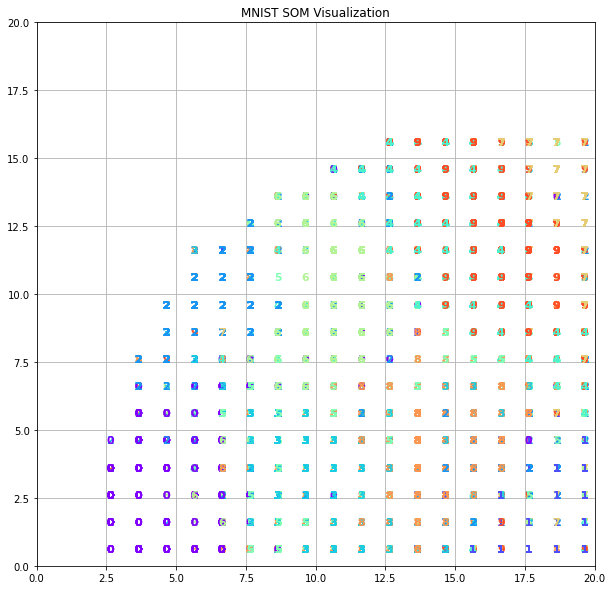

In [11]:
visualize_som(mnist_som, x_test, y_test, title="MNIST SOM Visualization")

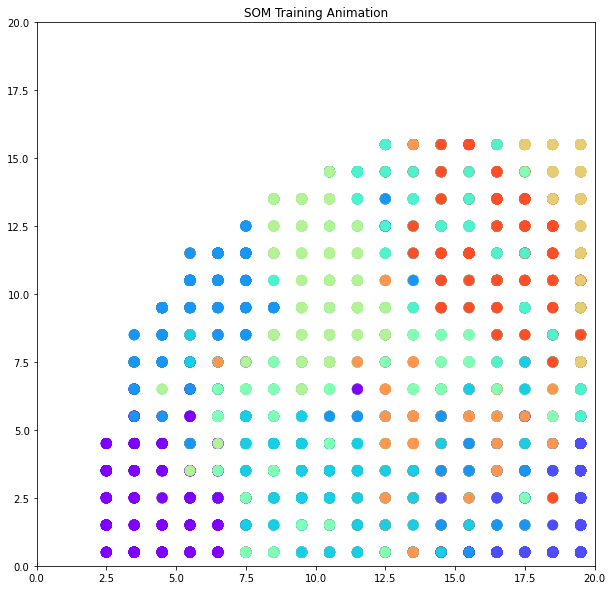

In [17]:
animate_som(mnist_som, x_test, y_test, num_iterations=100, interval=200)

In [9]:
som_state = mnist_som.compress()
decompressed_som = SOM.decompress(som_state)

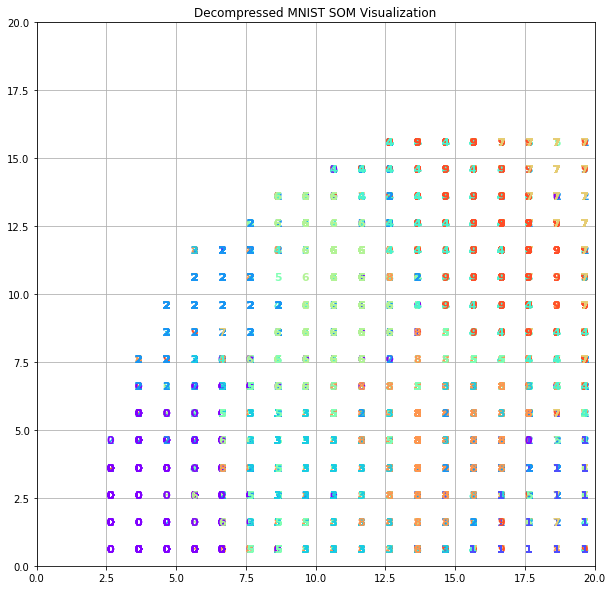

In [14]:
visualize_som(
    decompressed_som, x_test, y_test, title="Decompressed MNIST SOM Visualization"
)

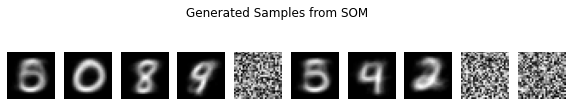

In [10]:
new_samples = decompressed_som.generate(n_samples=10)

plt.figure(figsize=(10, 2))
for i, sample in enumerate(new_samples):
    plt.subplot(1, 10, i + 1)
    plt.imshow(sample.reshape(28, 28), cmap="gray")
    plt.axis("off")
plt.suptitle("Generated Samples from SOM")
plt.show()

### Latent space

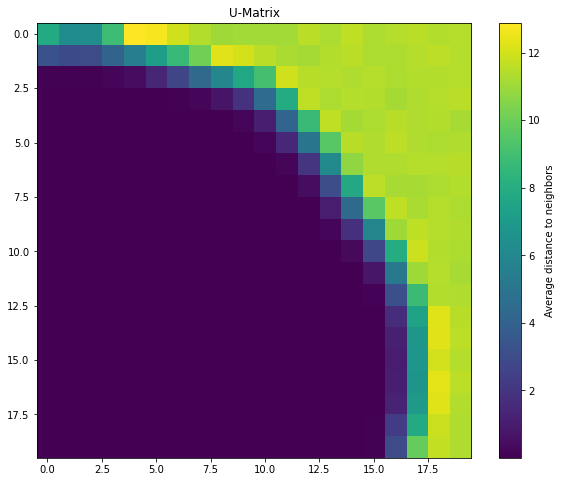

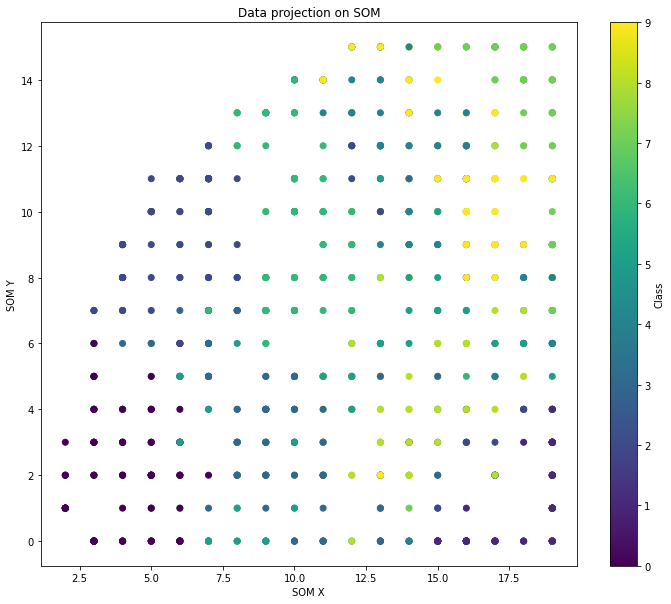

In [11]:
def visualize_umatrix(som, title="U-Matrix"):
    umatrix = som.compute_umatrix()
    plt.figure(figsize=(10, 8))
    plt.imshow(umatrix, cmap='viridis')
    plt.colorbar(label='Average distance to neighbors')
    plt.title(title)
    plt.show()

def visualize_data_projection(som, data, labels):
    projected = som.project_data(data)
    plt.figure(figsize=(12, 10))
    plt.scatter(projected[:, 0], projected[:, 1], c=labels, cmap='viridis')
    plt.colorbar(label='Class')
    plt.title('Data projection on SOM')
    plt.xlabel('SOM X')
    plt.ylabel('SOM Y')
    plt.show()

visualize_umatrix(mnist_som)
subset_size = 1000
subset_indices = np.random.choice(len(x_train), subset_size, replace=False)
visualize_data_projection(mnist_som, x_train[subset_indices], y_train[subset_indices])

## Lego Dataset

In [12]:
img_size = (32, 32)

(x_train, y_train), _ = load_custom_dataset(img_size=img_size, num_classes=5)

x_train = x_train.reshape(x_train.shape[0], -1) / 255.0

5it [00:07,  1.47s/it]


### Preprocessing


In [13]:
from sklearn.preprocessing import MinMaxScaler

data_normalized = MinMaxScaler().fit_transform(x_train)

In [14]:
custom_som = SOM(x=20, y=20, input_dim=img_size[0] * img_size[1], learning_rate=5e-2, sigma=5.0)
custom_som.train(x_train, num_iterations=10000)

100%|██████████| 10000/10000 [00:40<00:00, 244.86it/s]


In [15]:
import matplotlib.pyplot as plt

def visualize_som(som: SOM, data: np.ndarray, labels: np.ndarray, title: str):
    plt.figure(figsize=(10, 10))
    for i, (x, y) in enumerate(som.map_vects(data)):
        plt.text(
            x + 0.5,
            y + 0.5,
            str(labels[i]),
            color=plt.cm.rainbow(labels[i] / 10.0),
            fontdict={"weight": "bold", "size": 11},
        )
    plt.xlim([0, som.x])
    plt.ylim([0, som.y])
    plt.grid()
    plt.title(title)
    plt.show()

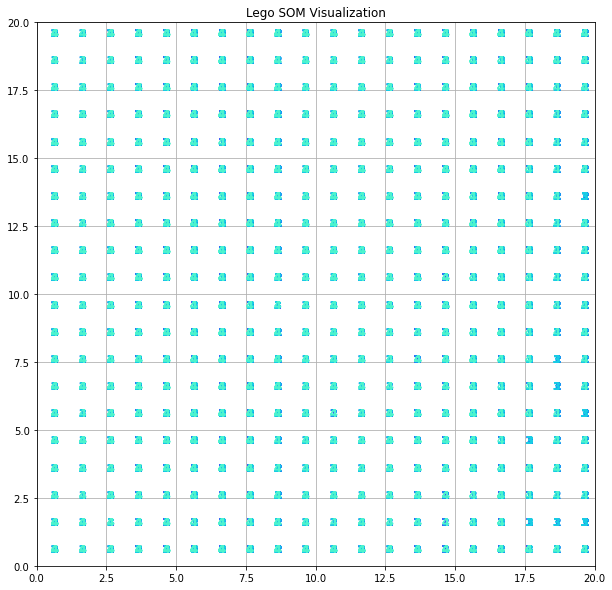

In [9]:
visualize_som(custom_som, x_train, y_train, title="Lego SOM Visualization")

In [16]:
som_state = custom_som.compress()
decompressed_som = SOM.decompress(som_state)

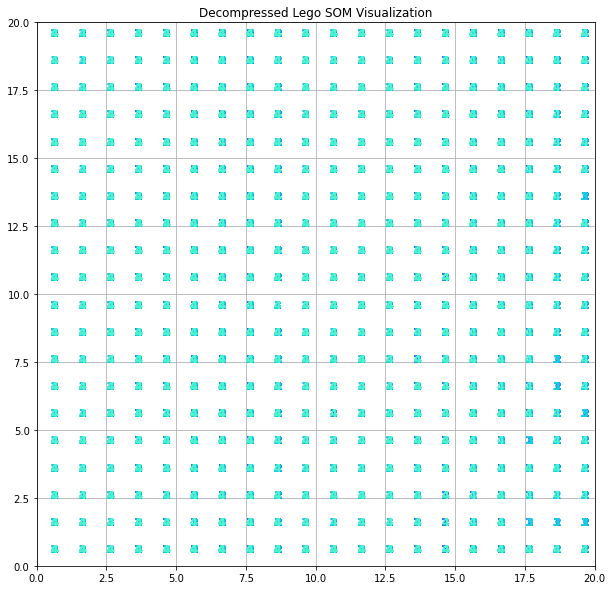

In [11]:
visualize_som(
    decompressed_som, x_train, y_train, title="Decompressed Lego SOM Visualization"
)

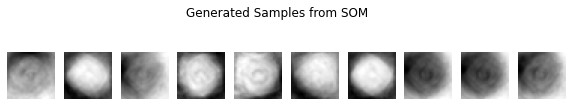

In [17]:
new_samples = decompressed_som.generate(n_samples=10)
plt.figure(figsize=(10, 2))
for i, sample in enumerate(new_samples):
    plt.subplot(1, 10, i + 1)
    # plt.imshow(sample.reshape(img_size[0], img_size[1]), cmap="gray")
    plt.imshow(sample.reshape(int(math.sqrt(len(new_samples[0]))), int(math.sqrt(len(new_samples[0])))), cmap="gray")
    plt.axis("off")
plt.suptitle("Generated Samples from SOM")
plt.show()

### Latent space

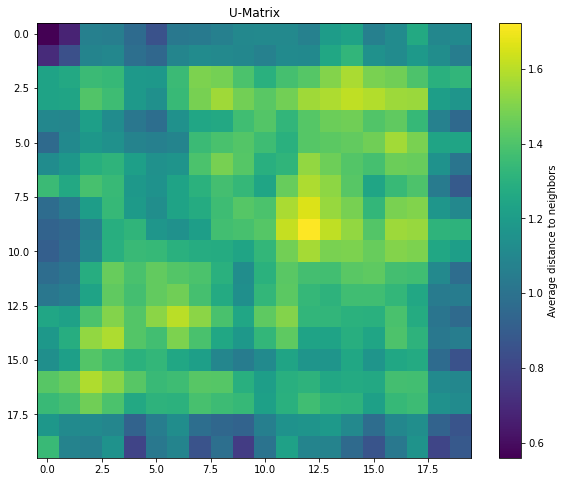

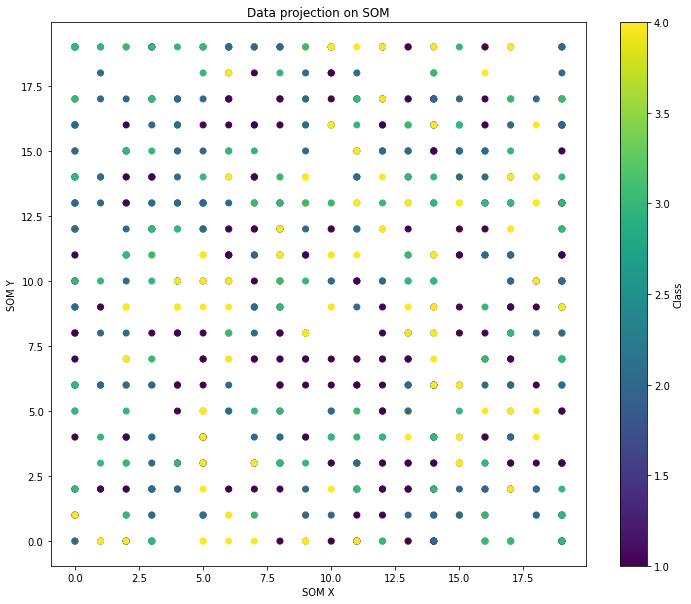

In [19]:
def visualize_umatrix(som, title="U-Matrix"):
    umatrix = som.compute_umatrix()
    plt.figure(figsize=(10, 8))
    plt.imshow(umatrix, cmap='viridis')
    plt.colorbar(label='Average distance to neighbors')
    plt.title(title)
    plt.show()

def visualize_data_projection(som, data, labels):
    projected = som.project_data(data)
    plt.figure(figsize=(12, 10))
    plt.scatter(projected[:, 0], projected[:, 1], c=labels, cmap='viridis')
    plt.colorbar(label='Class')
    plt.title('Data projection on SOM')
    plt.xlabel('SOM X')
    plt.ylabel('SOM Y')
    plt.show()

visualize_umatrix(custom_som)
subset_size = 1000
subset_indices = np.random.choice(len(x_train), subset_size, replace=False)
visualize_data_projection(custom_som, x_train[subset_indices], y_train[subset_indices])